In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                                    Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.2.4-tf
2.0.0


In [2]:
def plot_predictions(y_train, y_test, model_name, y_pred, model_name_gt = None, y_pred_gt = None):
    title = f"{model_name} Performance"
    print(f'Test RMSE for {model_name}: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    y_train = y_train[-100:]
    train_len = len(y_train)
    test_len = len(y_test)
    
    plt.figure(figsize=(20,8))
    plt.plot(range(train_len), y_train, label = 'y_train')
    plt.plot(range(train_len, train_len + test_len), y_test, c='g', label = 'y_test')
    plt.plot(range(train_len, train_len + test_len), y_pred, c='orange', ls='--', label = 'y_pred')
    if y_pred_gt is not None:
        print(f'Test RMSE for {model_name_gt}: ', np.sqrt(mean_squared_error(y_test, y_pred_gt)))
        plt.plot(range(train_len, train_len + test_len), y_pred_gt, c='red', ls='--', label = 'y_pred gt')
        title = f"{model_name} & {model_name_gt} Performance"
    plt.legend()
    plt.title(title)

In [3]:
flu_df = pd.read_csv('../data/clean_flu_data.csv').sort_values('date')
print(flu_df.shape)

(461, 51)


In [4]:
def minmax_transform(X_train, X_test):
    scalar = MinMaxScaler().fit(X_train)
    X_test = scalar.transform(X_test)
    X_train = scalar.transform(X_train)
    return X_train, X_test


state = 'North Carolina'
df_state_train = pd.read_csv('../data/state_flu_google/train/' +state+ '.csv')
df_state_test = pd.read_csv('../data/state_flu_google/test/' +state+ '.csv')


# Define X_train Time Series
flu_colname = state.lower().replace(" ","_")+"_flu"
X_train_ts = df_state_train[[flu_colname]]
X_test_ts = df_state_test[[flu_colname]]
X_train_ts, X_test_ts = minmax_transform(X_train_ts, X_test_ts)
X_all_ts = np.concatenate((X_train_ts, X_test_ts))
print(X_train_ts.shape, X_test_ts.shape, X_all_ts.shape)

# Define X_train with GT
gt_columns = list(df_state_train.columns.difference([flu_colname, 'date', 'target']))
X_train_gt = df_state_train[gt_columns+[flu_colname]]
X_test_gt = df_state_test[gt_columns+[flu_colname]]
X_train_gt, X_test_gt = minmax_transform(X_train_gt, X_test_gt)
X_all_gt = np.vstack((X_train_gt, X_test_gt))
print(X_train_gt.shape, X_test_gt.shape, X_all_gt.shape)


# Define X_train with other states
df_state_train = df_state_train.drop(gt_columns, 1)
df_state_test = df_state_test.drop(gt_columns, 1)
df_state_train = pd.merge(flu_df.drop(state,1), df_state_train, on = 'date', how = 'inner')
df_state_test = pd.merge(flu_df.drop(state,1), df_state_test, on = 'date', how = 'inner')
state_columns = list(df_state_train.columns.difference([flu_colname, 'date', 'target']))
X_train_states = df_state_train[state_columns+[flu_colname]]
X_test_states = df_state_test[state_columns+[flu_colname]]
X_train_states, X_test_states = minmax_transform(X_train_states, X_test_states)
X_all_state = np.vstack((X_train_states, X_test_states))
print(X_train_states.shape, X_test_states.shape, X_all_state.shape)






# df_state_gt_train = df_state_train[gt_columns]
# df_state_train = df_state_train.drop(gt_columns, 1)
# df_state_gt_test = df_state_test[gt_columns]
# df_state_test = df_state_test.drop(gt_columns, 1)

# df_state_train = pd.merge(flu_df.drop(state,1), df_state_train, on = 'date', how = 'inner')
# df_state_test = pd.merge(flu_df.drop(state,1), df_state_test, on = 'date', how = 'inner')

# # Add in 52-lag data
# # for lag in range(1,53):
# #     df_state_train[f"lag_{lag}"] = df_state_train[flu_colname].shift(lag).fillna(method = 'bfill')
# #     df_state_test[f"lag_{lag}"] = df_state_test[flu_colname].shift(lag).fillna(method = 'bfill')

# print(df_state_gt_train.shape)
# print(df_state_gt_test.shape)
# print(df_state_train.shape)
# print(df_state_test.shape)

(368, 1) (92, 1) (460, 1)
(368, 97) (92, 97) (460, 97)
(368, 50) (92, 50) (460, 50)


In [5]:
# Define target
target = 'target'
train_len = len(df_state_train)
df_state = pd.concat((df_state_train, df_state_test), axis=0)
y_all = df_state[[flu_colname]].shift(-4).fillna(method = 'ffill')
y_train = y_all[:train_len]
y_test = y_all[train_len:]

# y_train = df_state_train[[target]]
# y_test = df_state_test[[target]]
y_train, y_test = minmax_transform(y_train, y_test)

y_all = np.concatenate((y_train, y_test))

print(y_train.shape, y_test.shape, y_all.shape)

(368, 1) (92, 1) (460, 1)


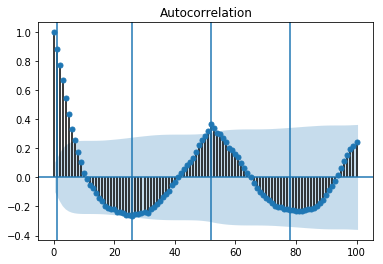

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_state_train['target'].values, lags=100)
plt.axvline(1)
plt.axvline(26)
plt.axvline(26*2)
plt.axvline(26*3)
plt.show()

# Try out different models

### Persistence

Test RMSE for Persistence:  0.22244448583369383


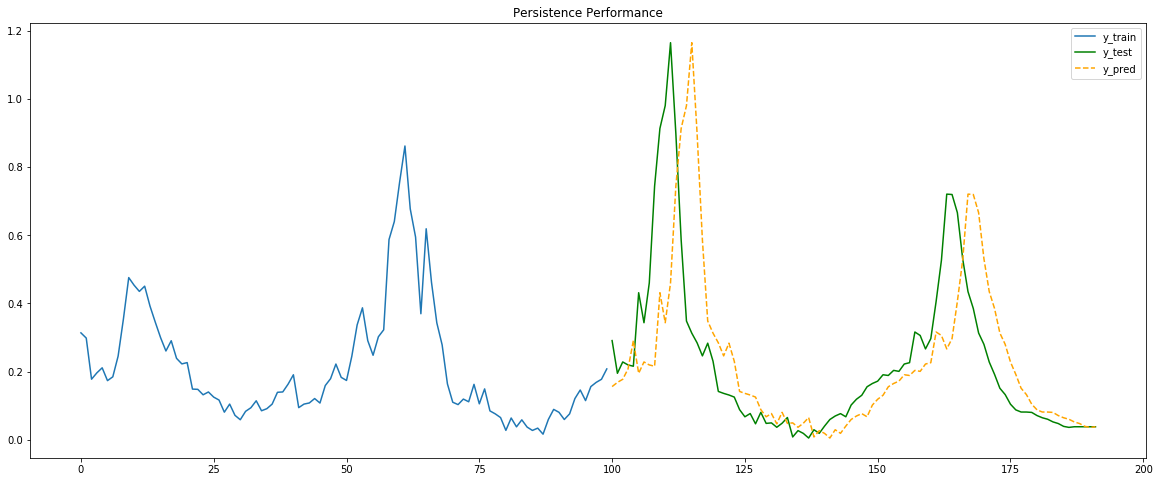

In [7]:
# y_train_max = np.max(y_train)
plot_predictions(y_train, y_test, 'Persistence', X_test_ts)

### AR and Airline Model

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

def walk_forward_ts(X_train_ts, X_all_ts, lags, model_name = 'airline'):
    train_len = len(X_train_ts)
    test_len = len(X_all_ts) - train_len 
    y_pred = []

    for t in range(test_len):
        if t%(test_len//3) == 0: print(f"Finished {t}/{test_len}")
        X_train_temp = X_all_ts[:train_len+t]
        if model_name == 'airline':
            airline = SARIMAX(X_train_temp, order = (1,0,1), seasonal_order = (0,1,1,52)).fit()
            pred = airline.forecast(1)
        elif model_name == 'ar':
            AR = AutoReg(X_train_temp, lags=lags).fit()
            pred = AR.predict(start=X_train_temp.shape[0], end=X_train_temp.shape[0])
        
        y_pred.append(pred)
    return y_pred

Finished 0/92
Finished 30/92
Finished 60/92
Finished 90/92
Test RMSE for AR:  0.23427894805919494


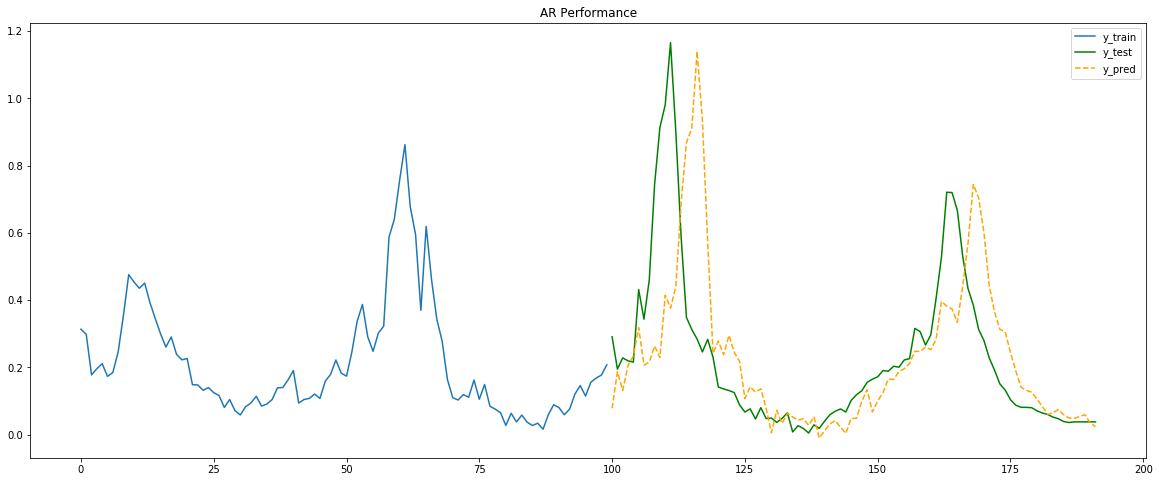

In [9]:
# Autoreg
y_pred = walk_forward_ts(X_train_ts, X_all_ts, lags=52, model_name = 'ar')
plot_predictions(y_train, y_test, 'AR', y_pred)

### Random Forest

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   16.1s finished
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   12.0s finished
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Test RMSE for rf:  0.18837342486258601
Test RMSE for rf_gt:  0.19177273788475993


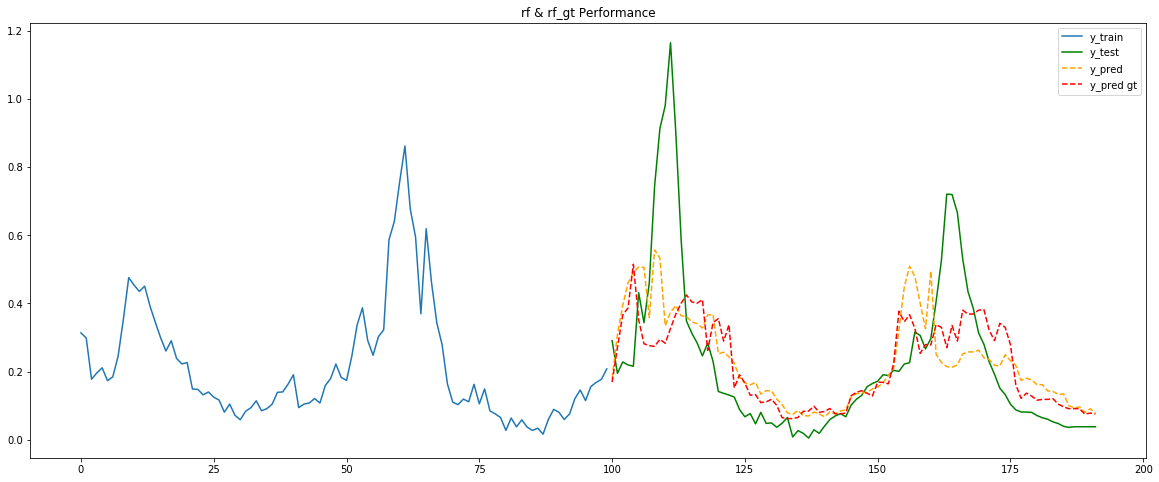

In [10]:
param_grid = {'n_estimators' : [200, 300],
              'max_depth' : [5, 10, 20]}
tscv = TimeSeriesSplit(n_splits=5)

rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2, verbose=1).fit(X_train_states, y_train)
y_pred = rf.predict(X_test_states)

rf_gt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=tscv, n_jobs=2, verbose=1).fit(X_train_gt, y_train)
y_pred_gt = rf_gt.predict(X_test_gt)

plot_predictions(y_train, y_test, 'rf', y_pred, 'rf_gt', y_pred_gt)

In [14]:
importances = rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Most important features rf:")
print(np.array(state_columns+[flu_colname])[indices][:20])

importances = rf_gt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Most important features rf:")
np.array(gt_columns+[flu_colname])[indices][:20]

Most important features rf:
['Louisiana' 'Texas' 'Georgia' 'Vermont' 'north_carolina_flu'
 'South Carolina' 'Maine' 'Arizona' 'Oregon' 'District of Columbia'
 'Virginia' 'New York' 'Washington' 'Connecticut' 'Mississippi' 'Nebraska'
 'Idaho' 'Hawaii' 'Missouri' 'Delaware']
Most important features rf:


array(['north_carolina_flu', 'the flu virus',
       'how long is flu contagious', 'symptoms of flu',
       'how long contagious', 'stomach flu', 'how long flu',
       'flu a symptoms', 'pneumonia', 'bronchitis', 'medicine for flu',
       'is flu contagious', 'symptoms of the flu', 'flu symptoms',
       'flu medicine', 'flu how long', 'flu children', 'the flu symptoms',
       'how long does the flu last', 'contagious flu'], dtype='<U30')

### XGBoost

In [17]:
import xgboost as xgb

param_grid = {'alpha': [1e-2, 1],
              'max_depth' : [5, 7, 9],
              'min_child_weight': [3, 5, 7],
              'gamma': [1e-2, 1],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

model = xgb.XGBRegressor(learning_rate = 0.01, n_estimators= 1000, early_stopping_rounds = 50)

xgb_b = RandomizedSearchCV(model, 
                         param_distributions=param_grid, 
                         cv=tscv, 
                         n_jobs=2,
                         n_iter=20,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         random_state=47
                        ).fit(X_train_states, y_train)
y_pred = xgb_b.predict(X_test_states)

xgb_gt = RandomizedSearchCV(model, 
                         param_distributions=param_grid, 
                         cv=tscv, 
                         n_jobs=2,
                         n_iter=20,
                         scoring='neg_mean_squared_error',
                         verbose=1,
                         random_state=47
                        ).fit(X_train_gt, y_train)
y_pred_gt = xgb_gt.predict(X_test_gt)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   51.0s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.2min finished


Test RMSE for xgb:  0.1851640672482231
Test RMSE for xgb_gt:  0.18119798088315367


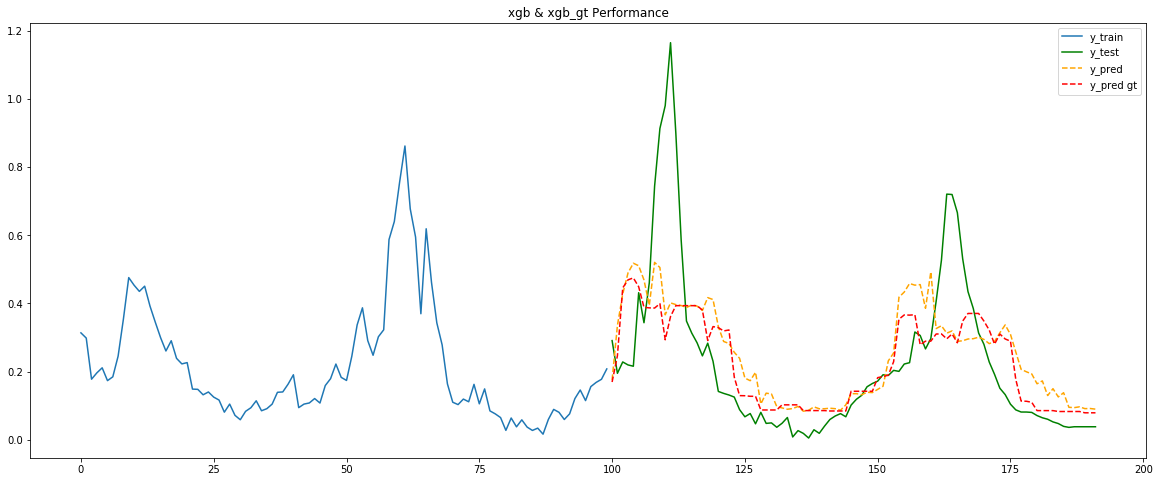

In [18]:
plot_predictions(y_train, y_test, 'xgb', y_pred, 'xgb_gt', y_pred_gt)

In [ ]:

# dtrain = xgb.DMatrix(df_state_train[X_train_predictors], y_train)
# dvalid = xgb.DMatrix(df_state_test[X_train_predictors], y_test)
# dtrain_gt = xgb.DMatrix(pd.concat((df_state_train[X_train_predictors], df_state_gt_train),axis=1), y_train)
# dvalid_gt = xgb.DMatrix(pd.concat((df_state_test[X_train_predictors], df_state_gt_test),axis=1), y_test)

# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# watchlist_gt = [(dtrain_gt, 'train'), (dvalid_gt, 'valid')]

# params = xgb_gt.best_estimator_.get_xgb_params()

# model = xgb.train(params = params, 
#                   dtrain = dtrain_gt, 
#                   num_boost_round = 1000, 
#                   evals = watchlist_gt, 
#                   early_stopping_rounds = 50, 
#                   verbose_eval = 50)

In [ ]:
# from xgboost import plot_importance

# fg,ax = plt.subplots(1,1,figsize=(12,20))
# plot_importance(model, ax=ax)

### Vanilla NN

In [19]:
def create_NN(X,y,batch_size,epochs,verbose):
    tf.random.set_seed(4747)
    np.random.seed(4747)
    n_units = 64
    drop_rate = .2
    optimizer = RMSprop(1e-4)
    loss = "mse"
    batch_size = batch_size
    epochs = epochs
    validation_split = 0.2
    verbose = verbose
    
    model = tf.keras.Sequential()
    model.add(Dense(input_dim=(X.shape[1]),units = n_units,activation = 'relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(units = n_units,activation = 'relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss)
    es = EarlyStopping(patience=10)
    model.fit(X,y,
              batch_size=batch_size, epochs=epochs, 
              validation_split=validation_split,
              verbose=verbose, callbacks=[es])
    return model

Test RMSE for nn:  0.16155083586751418
Test RMSE for nn_gt:  0.22476411448328124


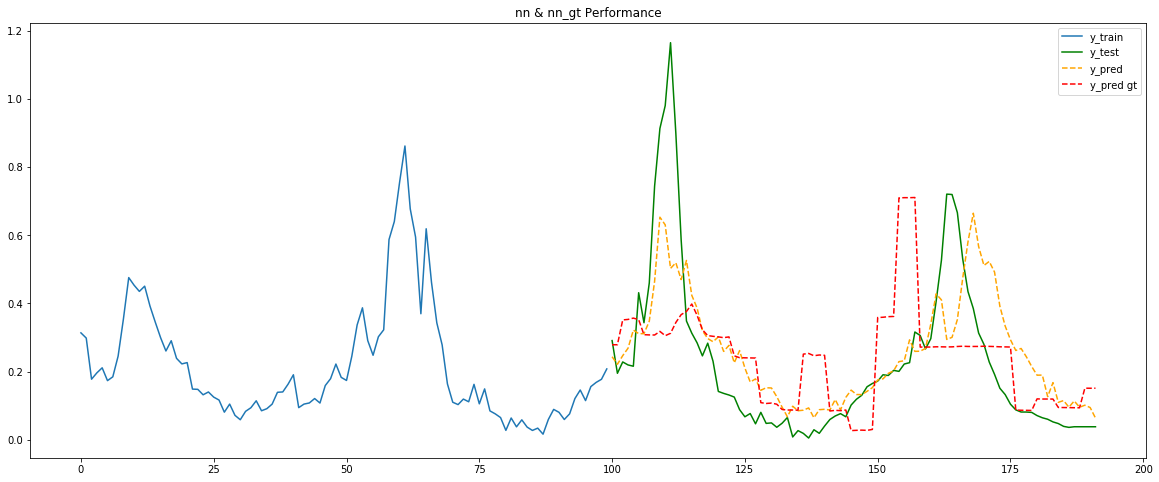

In [20]:
nn = create_NN(X_train_states, y_train,32,100,0)
y_pred = nn.predict(X_test_states)
nn_gt = create_NN(X_train_gt, y_train,32,100,0)
y_pred_gt = nn_gt.predict(X_test_gt)

plot_predictions(y_train, y_test, 'nn', y_pred, 'nn_gt', y_pred_gt)

In [21]:
# def walk_forward_prediction(model_fn, X_all, X_train, y_all):
#     size = len(X_train)
#     max_train_size = size
#     y_pred = []
#     test_len = len(y_test)

#     for t in range(test_len):
#         if t%(test_len//10) == 0: print(f"Finished {t}/{test_len}")
#         X_train_temp, X_test_temp = X_all[size+t-max_train_size:size+t], X_all[size+t:]
#         y_train_temp = y_all[size+t-max_train_size:size+t]
#         model = model_fn(X_train_temp, y_train_temp,32,100,0)
#         pred = model.predict(X_test_temp)
#         y_pred.append(pred[0])
#     return y_pred

# nn_fw_pred = walk_forward_prediction(create_NN, X_all, X_train, y_all)
# nn_fw_pred_gt = walk_forward_prediction(create_NN, X_all_gt, X_train_gt, y_all)
# plot_predictions(y_train, y_test, 'nn_fw',  nn_fw_pred, 'nn_fw_gt',  nn_fw_pred_gt)

In [ ]:
# optimizer = "rmsprop"
# loss = "mae"

# n_steps, n_features = X_train.shape[0], X_train.shape[1]
# n_units = 64
# batch_size = 32
# epochs = 10
# validation_split = 0.2
# verbose = 1

# model = Sequential()
# model.add(SimpleRNN(n_units, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1, activation='relu'))
          
# # Compile model
# model.compile(optimizer=optimizer, loss=loss)
# print(model.summary())

# # Train model
# history = model.fit(X_train.reshape(1,X_train.shape[0],X_train.shape[1]),
#                     y_train.reshape(1,y_train.shape[0]),
#                     batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)